### Wavelete coherence 

In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates

from xfrites.conn.conn_spec  import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Bias of the wavelet coherence 

Following Lachaux et. al. (2002) the bias fo the wavelet coherence can be computed as:

$B = \left(1 + 2\frac{n_{cy}}{n_{co}}\right)^{-1}$

where, $n_{cy}$ is the number of cycles of the wavelet within the integration window $\delta$, and $n_{co}$ the number of cycles of the wavelet. The integration window is given by:

$\delta = n_{cy}/f$

Those function could be used to fit the bias of the wavelet coherence computed for white noise signals.

With our terminology, since we input $\delta$ (sm_times) to the function the bias can be written as:

$B = \left(1 + 2\frac{f\delta}{n_{co}}\right)^{-1}$

From this equation it is expected that the bias will be frequency dependent if $n_{co}$ is constant, and frequency independent if $n_{co}$ is proportional to frequency let's say $n_{co}=f/\sigma_t$, then:

$B = \left(1 + 2\delta\sigma_{t}\right)^{-1}$

By comparing the wavelet coherence measured for white noise we can validate the expression above.

In [3]:
def _bias_lachaux(sm_times, freqs, n_cycles):
    return (1+2*sm_times*freqs/n_cycles)**-1

### Bias of the metric - White noise vs. Analytical

In [4]:
n  = 3650
sf = 1000

eta = xr.DataArray( np.random.normal(0,1,size=(1,30,n)), 
                    dims=("trials","roi","times"), 
                    coords={"times": np.arange(n)/sf})

#### Constant $\delta$, and $n_{co}$ constant

In [ ]:
delta    = 1
freqs    = np.linspace(10,100,50)
n_cy     = np.linspace(1, 40, 20)

n_cycles = 7.

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode="morlet", n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel="square",
    sm_freqs=1, block_size=1
)

kw["sm_times"] = 0.3

coh_eta = []
for i in range( len(n_cy) ):
    # compute the coherence
    coh_eta += [conn_spec(eta, **kw)]

In [9]:
B   = []
B_t = []

for i in range( len(n_cy) ):
    B += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    #B_t += [(1 + 2*n_cy[i]/n_cycles)**-1 ]
    B_t += [_bias_lachaux(kw["sm_times"], freqs, n_cycles) ]

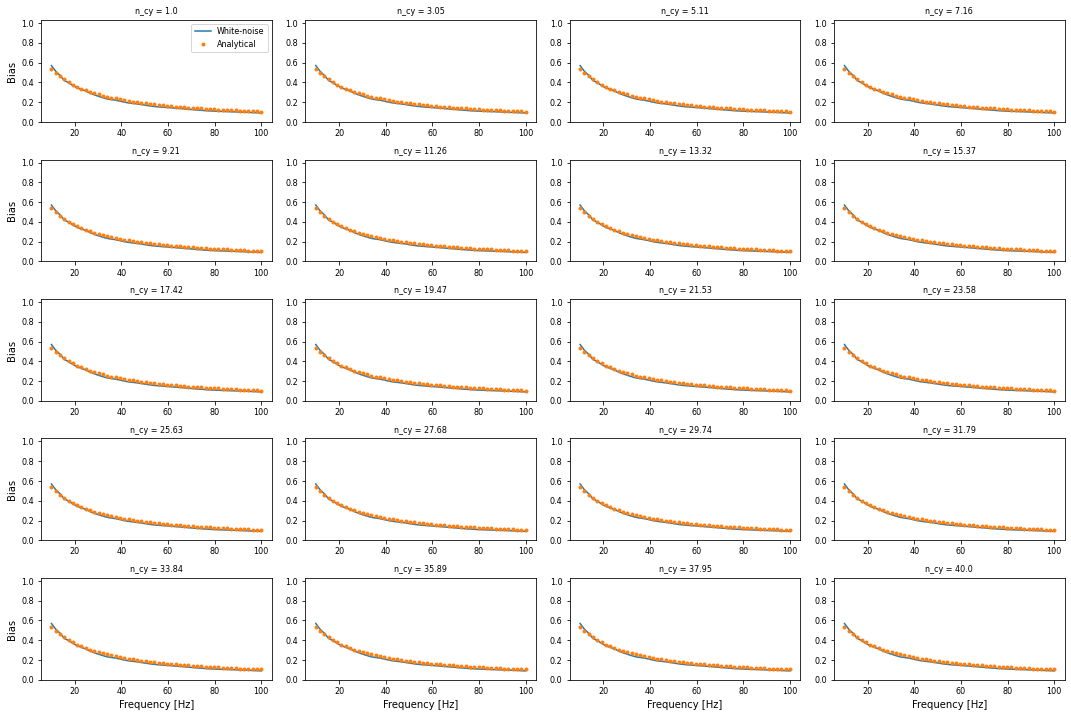

In [10]:
plt.figure(figsize=(15,10))
for i in range( len(n_cy) ):
    plt.subplot(5,4,i+1)
    plt.title(f"n_cy = {np.round(n_cy[i],2)}")
    plt.plot(freqs, B[i], '-')
    #plt.plot(freqs, [B_t[i]]*len(freqs), ".")
    plt.plot(freqs, B_t[i], ".")
    plt.ylim(0,1.03)
    if i==0: plt.legend(["White-noise", "Analytical"])
    if i>15: plt.xlabel("Frequency [Hz]")
    if i%4==0: plt.ylabel("Bias")
plt.tight_layout()

#### Constant $\delta$, and $n_{co}$ proportional to frequency

In [ ]:
delta    = 1
freqs    = np.linspace(10,100,50)
n_cy     = np.linspace(1, 40, 20)

n_cycles = freqs/2.

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode="morlet", n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel="square",
    sm_freqs=1, block_size=1
)

kw["sm_times"] = 0.3

coh_eta = []
for i in range( len(n_cy) ):
    # compute the coherence
    coh_eta += [conn_spec(eta, **kw)]

In [6]:
B   = []
B_t = []

for i in range( len(n_cy) ):
    B += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    #B_t += [(1 + 2*n_cy[i]/n_cycles)**-1 ]
    B_t += [_bias_lachaux(kw["sm_times"], freqs, n_cycles) ]

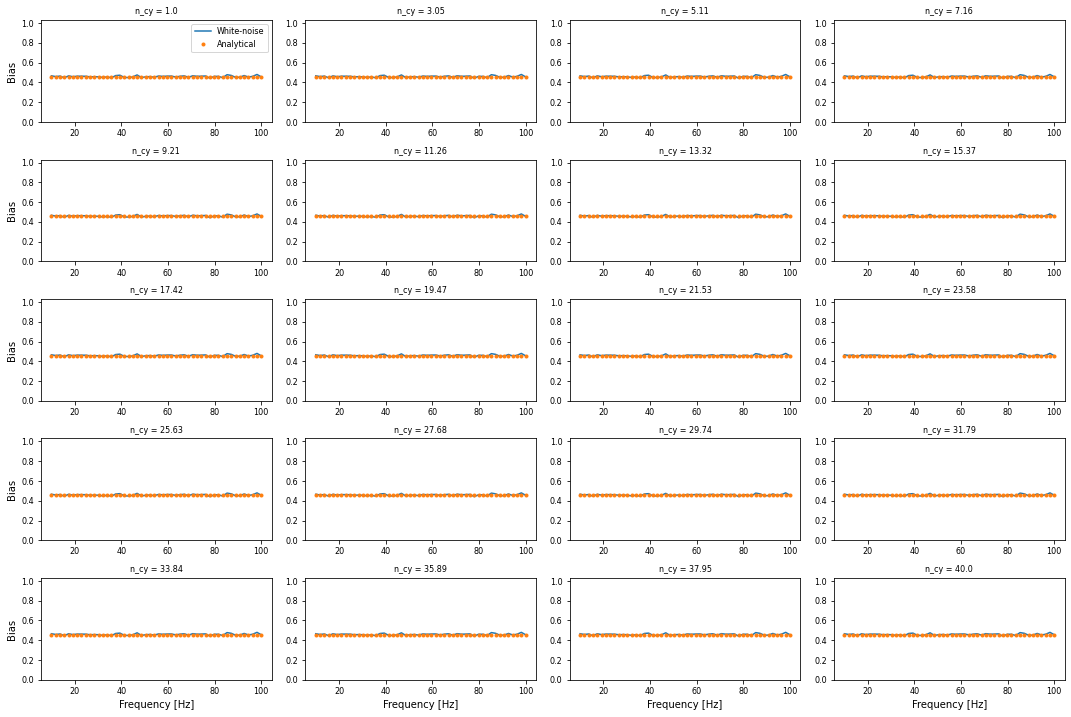

In [7]:
plt.figure(figsize=(15,10))
for i in range( len(n_cy) ):
    plt.subplot(5,4,i+1)
    plt.title(f"n_cy = {np.round(n_cy[i],2)}")
    plt.plot(freqs, B[i], '-')
    #plt.plot(freqs, [B_t[i]]*len(freqs), ".")
    plt.plot(freqs, B_t[i], ".")
    plt.ylim(0,1.03)
    if i==0: plt.legend(["White-noise", "Analytical"])
    if i>15: plt.xlabel("Frequency [Hz]")
    if i%4==0: plt.ylabel("Bias")
plt.tight_layout()

#### Variable $\delta$, and $n_{co}$ constant

In [ ]:
delta    = 1
freqs    = np.linspace(10,100,50)
n_cy     = np.linspace(1, 40, 20)

n_cycles = 7.

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode="morlet", n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel="square",
    sm_freqs=1, block_size=1
)



coh_eta = []
for i in range( len(n_cy) ):
    # compute the coherence
    kw["sm_times"] = n_cy[i]/freqs
    coh_eta += [conn_spec(eta, **kw)]

In [13]:
B   = []
B_t = []

for i in range( len(n_cy) ):
    B += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    #B_t += [(1 + 2*n_cy[i]/n_cycles)**-1 ]
    B_t += [_bias_lachaux(n_cy[i]/freqs, freqs, n_cycles) ]

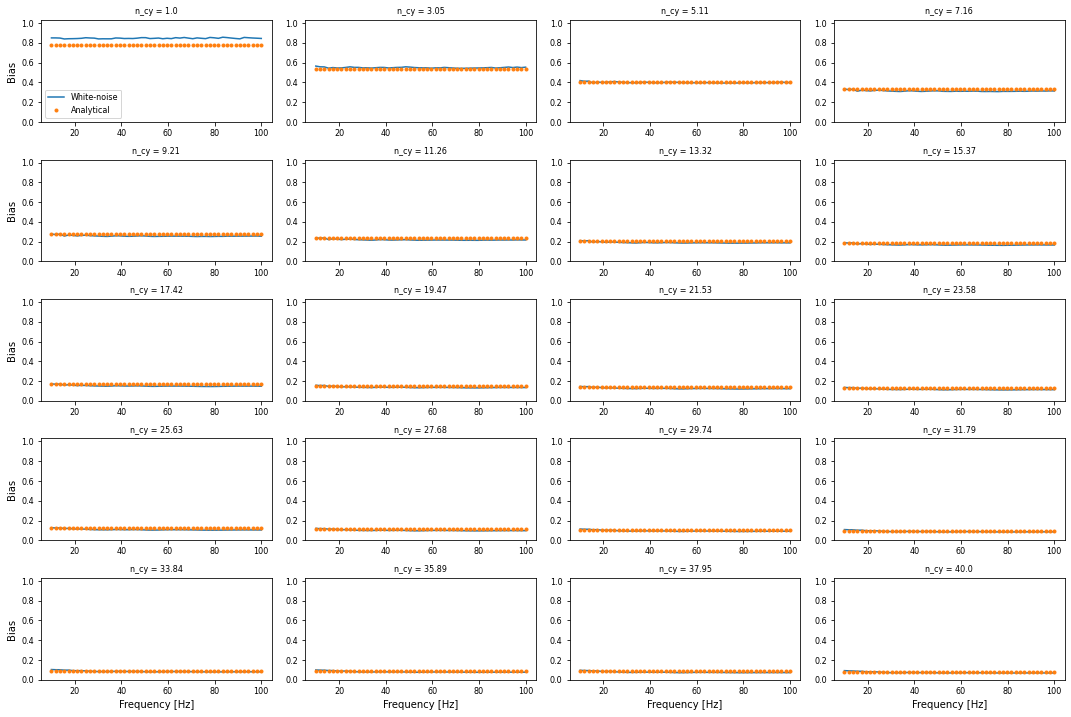

In [14]:
plt.figure(figsize=(15,10))
for i in range( len(n_cy) ):
    plt.subplot(5,4,i+1)
    plt.title(f"n_cy = {np.round(n_cy[i],2)}")
    plt.plot(freqs, B[i], '-')
    #plt.plot(freqs, [B_t[i]]*len(freqs), ".")
    plt.plot(freqs, B_t[i], ".")
    plt.ylim(0,1.03)
    if i==0: plt.legend(["White-noise", "Analytical"])
    if i>15: plt.xlabel("Frequency [Hz]")
    if i%4==0: plt.ylabel("Bias")
plt.tight_layout()

#### Variable $\delta$, and $n_{co}$ frequency dependent

In [ ]:
delta    = 1
freqs    = np.linspace(10,100,50)
n_cy     = np.linspace(1, 40, 20)

n_cycles = freqs/2.

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode="morlet", n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel="square",
    sm_freqs=1, block_size=1
)



coh_eta = []
for i in range( len(n_cy) ):
    # compute the coherence
    kw["sm_times"] = n_cy[i]/freqs
    coh_eta += [conn_spec(eta, **kw)]

In [16]:
B   = []
B_t = []

for i in range( len(n_cy) ):
    B += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    #B_t += [(1 + 2*n_cy[i]/n_cycles)**-1 ]
    B_t += [_bias_lachaux(n_cy[i]/freqs, freqs, n_cycles) ]

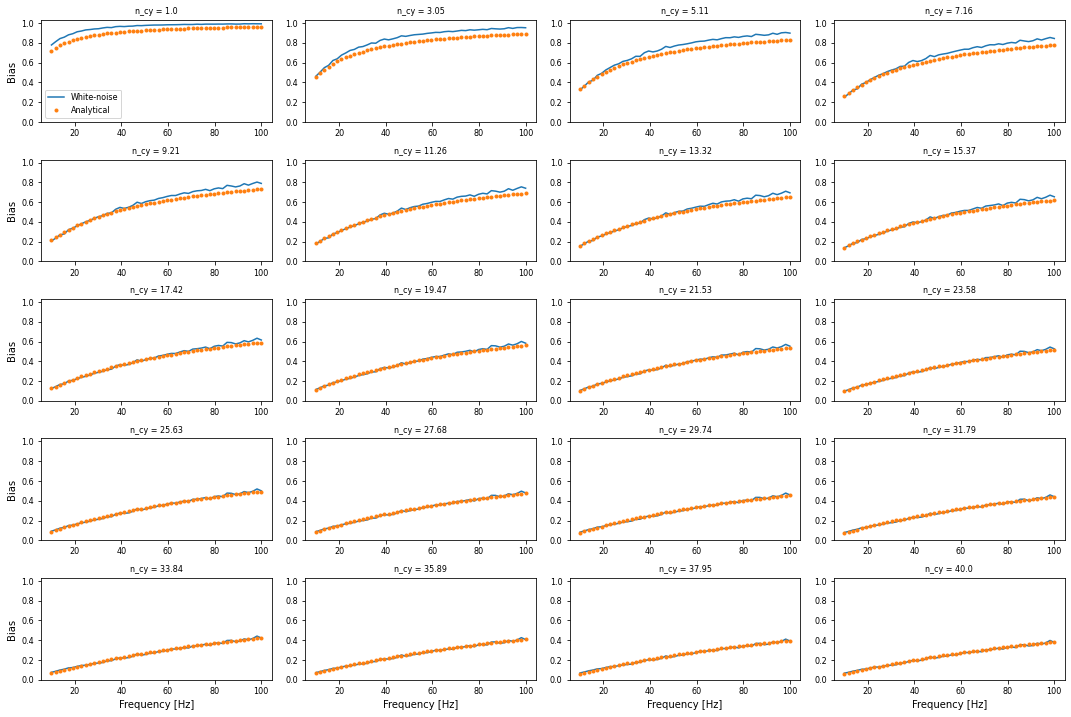

In [17]:
plt.figure(figsize=(15,10))
for i in range( len(n_cy) ):
    plt.subplot(5,4,i+1)
    plt.title(f"n_cy = {np.round(n_cy[i],2)}")
    plt.plot(freqs, B[i], '-')
    #plt.plot(freqs, [B_t[i]]*len(freqs), ".")
    plt.plot(freqs, B_t[i], ".")
    plt.ylim(0,1.03)
    if i==0: plt.legend(["White-noise", "Analytical"])
    if i>15: plt.xlabel("Frequency [Hz]")
    if i%4==0: plt.ylabel("Bias")
plt.tight_layout()